Fetching dataset from kaggle and installing all the dependencies

In [1]:
import os
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

os.environ["SPARK_HOME"] = "/usr/local/spark/spark-4.0.1-bin-hadoop3"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["SPARK_HOME"], "bin")

spark = SparkSession.builder \
    .appName("PySpark-Get-Started") \
    .getOrCreate()

print(spark)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/24 21:37:37 WARN Utils: Your hostname, Shreyass-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.154 instead (on interface en0)
25/11/24 21:37:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/24 21:37:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/24 21:37:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/24 21:37:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Loading 3 million rows and creating a dataframe

In [2]:
from pyspark.sql import functions as F

target_rows = 2000000
collected = None
count_so_far = 0

files = (
    spark._jvm.org.apache.hadoop.fs.FileSystem
    .get(spark._jsc.hadoopConfiguration())
    .listStatus(spark._jvm.org.apache.hadoop.fs.Path("/Users/shreyasjaiswal/Downloads/DIC-Project-Phase-II/archive"))
)

for f in files:
    path = f.getPath().toString()
    if "2019-Nov" not in path:
        continue
    if count_so_far >= target_rows:
        break

    print("Loading:", path)

    df = spark.read.csv(path, header=True, inferSchema=True)

    remaining = target_rows - count_so_far
    df = df.limit(remaining)

    if collected is None:
        collected = df
    else:
        collected = collected.union(df)

    count_so_far += df.count()

df = collected.limit(target_rows)

print("Loaded rows:", df.count())


Loading: file:/Users/shreyasjaiswal/Downloads/DIC-Project-Phase-II/archive/2019-Nov.csv


Loaded rows: 2000000


# 2.1 Data cleaning using PySpark

Handling Missing Values

In [3]:


from pyspark.sql.functions import col, sum

missing = df.select([sum(col(c).isNull().cast("int")).alias(c)
                     for c in df.columns])
missing.show()

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code| brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|         0|         0|         0|          0|       638812|293648|    0|      0|           0|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+



Dropping rows that are missing critical columns

In [4]:

critical_cols = ["product_id", "category_id", "price"]
df = df.dropna(subset=critical_cols)

Filling out missing values with mean

In [5]:

from pyspark.sql.functions import mean
numeric_cols = ["product_id", "price", "category_id"]

for colname in numeric_cols:
    df = df.withColumn(colname, col(colname).cast("double"))

for colname in numeric_cols:
    mean_val = df.select(mean(col(colname))).collect()[0][0]
    df = df.fillna({colname: mean_val})

Filling missing categorical values with most frequent values

In [6]:

categorical_cols = ["category_code", "brand"]

for colname in categorical_cols:

    mode_row = (df.groupBy(colname)
                  .count()
                  .orderBy("count", ascending=False)
                  .first())

    if mode_row is not None and mode_row[0] is not None:
        mode_val = mode_row[0]
        df = df.fillna({colname: mode_val})

Adding timestamp, hour, and weekday columns to the DataFrame.

In [7]:
from pyspark.sql.functions import to_timestamp, hour, dayofweek

df = df.withColumn("event_time", to_timestamp("event_time"))
df = df.withColumn("hour", hour("event_time"))
df = df.withColumn("day_of_week", dayofweek("event_time"))

print("Schema after timestamp conversion:")
df.select("event_time", "hour", "day_of_week").printSchema()

print("Sample rows with time features:")
df.select("event_time", "hour", "day_of_week").show(5)

Schema after timestamp conversion:
root
 |-- event_time: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)

Sample rows with time features:


+-------------------+----+-----------+
|         event_time|hour|day_of_week|
+-------------------+----+-----------+
|2019-10-31 20:00:00|  20|          5|
|2019-10-31 20:00:00|  20|          5|
|2019-10-31 20:00:01|  20|          5|
|2019-10-31 20:00:01|  20|          5|
|2019-10-31 20:00:01|  20|          5|
+-------------------+----+-----------+
only showing top 5 rows


Removing invalid or unrealistic prices

In [8]:
from pyspark.sql.functions import col

df = df.filter((col("price") >= 0) & (col("price") < 100000))

print("Schema after filtering prices:")
df.printSchema()

print("Sample rows after filtering:")
df.select("product_id", "price").show(5)

print("Total number of rows after filtering:", df.count())

Schema after filtering prices:
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: double (nullable = false)
 |-- category_id: double (nullable = false)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = false)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)

Sample rows after filtering:


+-----------+------+
| product_id| price|
+-----------+------+
|  1003461.0|489.07|
|  5000088.0|293.65|
|1.7302664E7| 28.31|
|  3601530.0|712.87|
|  1004775.0|183.27|
+-----------+------+
only showing top 5 rows


Total number of rows after filtering: 2000000


Encoding categories + adding frequency features for ML

In [9]:

!pip3 install numpy
from pyspark.ml.feature import StringIndexer, OneHotEncoder

df = df.drop("category_idx", "brand_idx", "category_vec", "brand_vec","event_type_idx")

indexer = StringIndexer(
    inputCols=["category_code", "brand", "event_type"],
    outputCols=["category_idx", "brand_idx", "event_type_idx"],
    handleInvalid="keep"
)
df = indexer.fit(df).transform(df)

from pyspark.sql import Window
from pyspark.sql.functions import count, col

brand_freq = df.groupBy("brand").agg(count("*").alias("brand_frequency"))
df = df.join(brand_freq, on="brand", how="left")

category_freq = df.groupBy("category_code").agg(count("*").alias("category_frequency"))
df = df.join(category_freq, on="category_code", how="left")
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(
    inputCols=["event_type_idx"],
    outputCols=["event_type_vec"],
    handleInvalid="keep"
)
df = encoder.fit(df).transform(df)

print("Sample rows after smart encoding:")
df.select("event_type", "event_type_vec", "brand", "brand_frequency",
          "category_code", "category_frequency").show(5, truncate=False)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


Sample rows after smart encoding:


+----------+--------------+------+---------------+-------------------------+------------------+
|event_type|event_type_vec|brand |brand_frequency|category_code            |category_frequency|
+----------+--------------+------+---------------+-------------------------+------------------+
|view      |(4,[0],[1.0]) |xiaomi|144072         |electronics.smartphone   |527382            |
|view      |(4,[0],[1.0]) |janome|5724           |appliances.sewing_machine|7454              |
|view      |(4,[0],[1.0]) |creed |870            |NULL                     |NULL              |
|view      |(4,[0],[1.0]) |lg    |26853          |appliances.kitchen.washer|40456             |
|view      |(4,[0],[1.0]) |xiaomi|144072         |electronics.smartphone   |527382            |
+----------+--------------+------+---------------+-------------------------+------------------+
only showing top 5 rows


Building the ML feature vector and targeting the label.

In [10]:

from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler

df = df.withColumn("purchases", when(col("event_type") == "purchase", 1).otherwise(0))

assembler = VectorAssembler(
    inputCols=[
        "price",
        "hour",
        "day_of_week",
        "category_idx",
        "brand_idx",
        "brand_frequency",
        "category_frequency",
        "event_type_idx"
    ],
    outputCol="features",
    handleInvalid="skip"
)


final_ml_df = assembler.transform(df).select(
    "features",
    "event_type",
    "purchases",
    "user_id",
    "user_session",
    "product_id",
    "category_code",
    "brand",
    "price",
    "event_time",
    "hour",
    "day_of_week"
)

print("Schema of final ML dataset:")
final_ml_df.printSchema()

print("Sample rows of final ML dataset:")
final_ml_df.show(5, truncate=False)

print("Total rows:", final_ml_df.count())

print("Feature vector size:")
print(f"Number of features: {len(final_ml_df.first()['features'])}")

Schema of final ML dataset:
root
 |-- features: vector (nullable = true)
 |-- event_type: string (nullable = true)
 |-- purchases: integer (nullable = false)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- product_id: double (nullable = false)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = false)
 |-- event_time: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)

Sample rows of final ML dataset:


+-------------------------------------------+----------+---------+---------+------------------------------------+----------+---------------------------+-------+-----+-------------------+----+-----------+
|features                                   |event_type|purchases|user_id  |user_session                        |product_id|category_code              |brand  |price|event_time         |hour|day_of_week|
+-------------------------------------------+----------+---------+---------+------------------------------------+----------+---------------------------+-------+-----+-------------------+----+-----------+
|[11.71,21.0,5.0,4.0,994.0,73.0,53641.0,0.0]|view      |0        |512891781|d802a966-9419-4b68-8902-e00855aac0e9|4800426.0 |electronics.audio.headphone|edifier|11.71|2019-10-31 21:53:04|21  |5          |
|[11.71,21.0,5.0,4.0,994.0,73.0,53641.0,0.0]|view      |0        |512891781|d802a966-9419-4b68-8902-e00855aac0e9|4800426.0 |electronics.audio.headphone|edifier|11.71|2019-10-31 21:53:1

Total rows: 1240759
Feature vector size:


Number of features: 8


# 2.2 Exploratory data analysis (EDA) using PySpark

Installing and importing plotting + analysis libraries

In [11]:
!pip3 install matplotlib seaborn pandas

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, date_format

sns.set(style="whitegrid")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


Displaying price stats and counting unique users/products/brands/sessions.

In [12]:
print("Summary Statistics for Price")

df.select("price").describe().show()

print("Unique Value Counts")

from pyspark.sql.functions import countDistinct

df.select([
    countDistinct("user_id").alias("unique_users"),
    countDistinct("product_id").alias("unique_products"),
    countDistinct("brand").alias("unique_brands"),
    countDistinct("user_session").alias("unique_sessions")
]).show()

Summary Statistics for Price


+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|           2000000|
|   mean|292.19961629965064|
| stddev| 348.5766888566505|
|    min|               0.0|
|    max|           2574.07|
+-------+------------------+

Unique Value Counts


+------------+---------------+-------------+---------------+
|unique_users|unique_products|unique_brands|unique_sessions|
+------------+---------------+-------------+---------------+
|      300008|          87121|         2921|         451259|
+------------+---------------+-------------+---------------+



Distribution of Event Types (User Behavior)

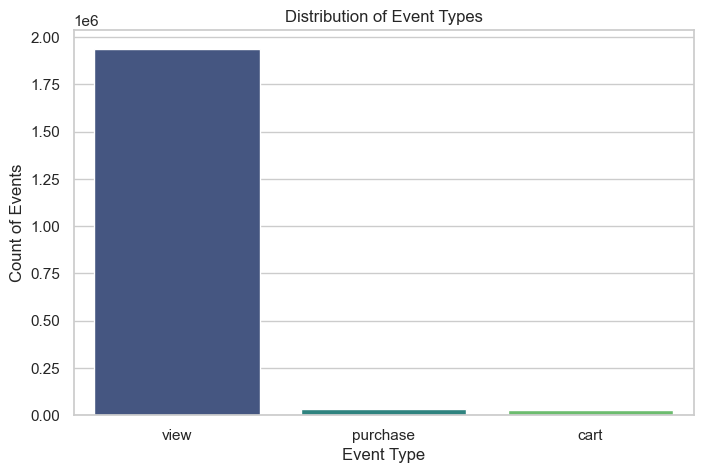

In [13]:

event_counts = df.groupBy("event_type").count().orderBy("count", ascending=False)

pdf_events = event_counts.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x="event_type", y="count", data=pdf_events, hue="event_type", palette="viridis", legend=False)

plt.title("Distribution of Event Types")
plt.ylabel("Count of Events")
plt.xlabel("Event Type")
plt.show()

Temporal Analysis (Activity by Hour)

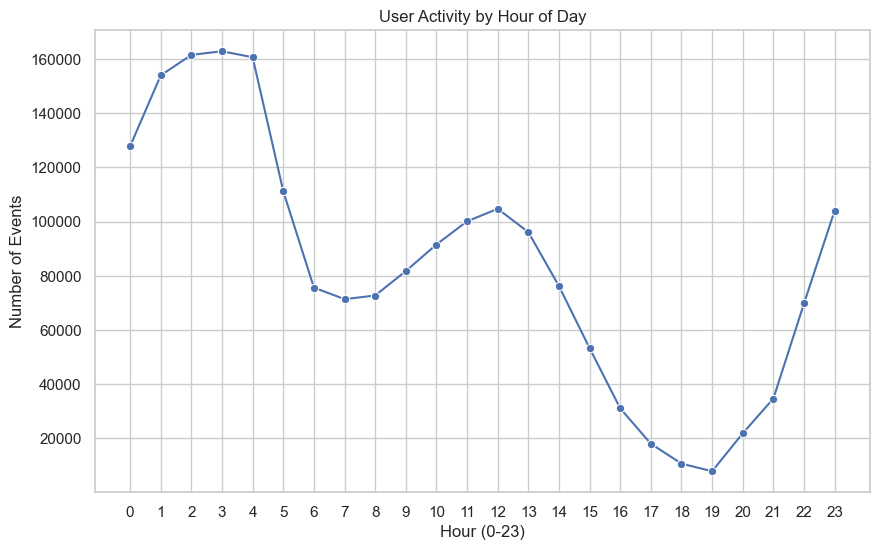

In [14]:

df = df.withColumn("event_timestamp", to_timestamp(col("event_time"), "yyyy-MM-dd HH:mm:ss z"))

df_time = df.withColumn("hour", hour("event_timestamp"))

hourly_activity = df_time.groupBy("hour").count().orderBy("hour")
pdf_hourly = hourly_activity.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x="hour", y="count", data=pdf_hourly, marker="o", color="b")
plt.title("User Activity by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Number of Events")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Top 10 Brands by Activity

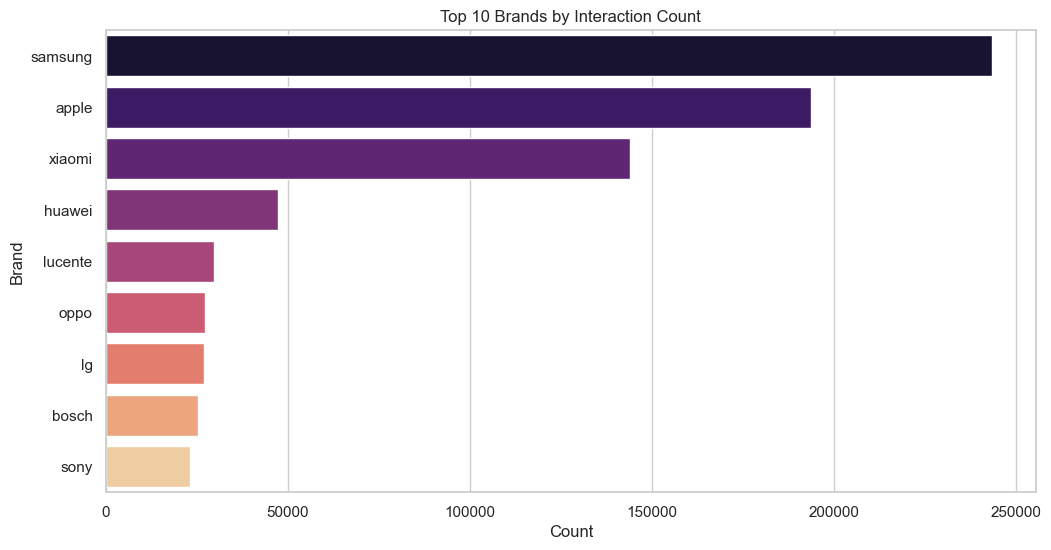

In [15]:

top_brands = df.groupBy("brand").count().orderBy(col("count").desc()).limit(10)
pdf_brands = top_brands.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="brand", data=pdf_brands, hue="brand", palette="magma", legend=False)

plt.title("Top 10 Brands by Interaction Count")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.show()

Price Distribution (Handling Outliers)

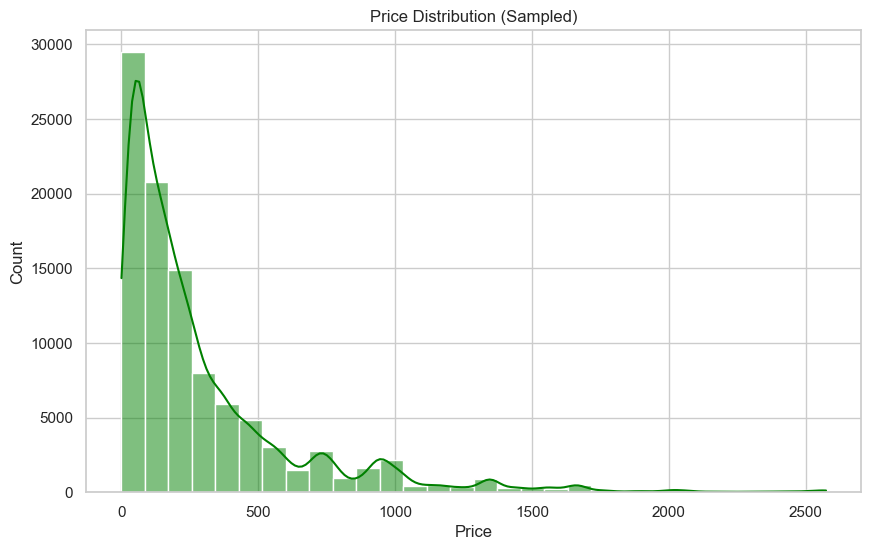

In [16]:

sample_df = df.select("price").sample(withReplacement=False, fraction=0.05).toPandas()

plt.figure(figsize=(10, 6))

sns.histplot(sample_df['price'], bins=30, kde=True, color='green')

plt.title("Price Distribution (Sampled)")
plt.xlabel("Price")
plt.ylabel("Count")

plt.show()

Average Price by Event Type

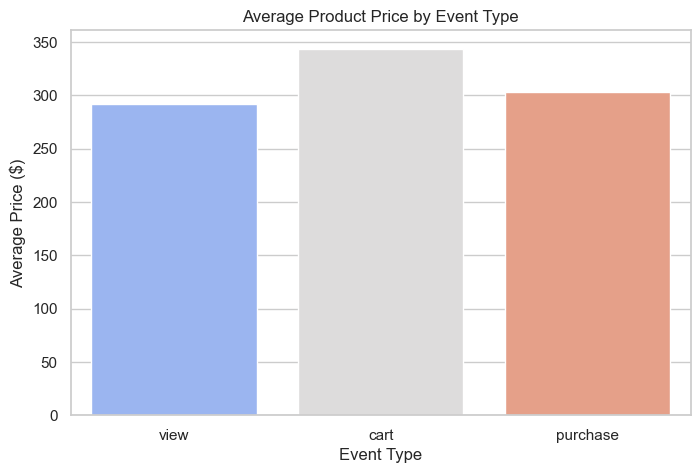

In [17]:
from pyspark.sql.functions import avg

avg_price_event = df.groupBy("event_type").agg(avg("price").alias("avg_price"))
pdf_avg_price = avg_price_event.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x="event_type", y="avg_price", data=pdf_avg_price, hue="event_type", palette="coolwarm", legend=False)
plt.title("Average Product Price by Event Type")
plt.ylabel("Average Price ($)")
plt.xlabel("Event Type")
plt.show()

Daily User Traffic Pattern (Weekly Seasonality)

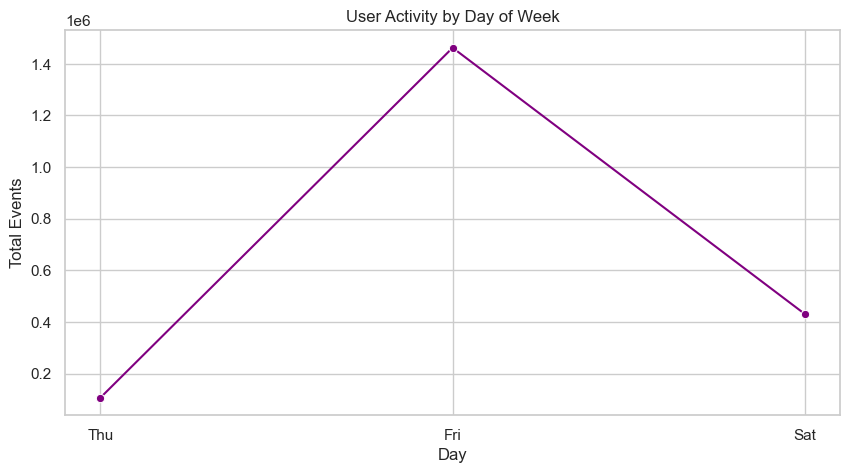

In [18]:
from pyspark.sql.functions import dayofweek

df_week = df.withColumn("day_of_week", dayofweek("event_timestamp"))

weekly_activity = df_week.groupBy("day_of_week").count().orderBy("day_of_week")
pdf_weekly = weekly_activity.toPandas()

day_map = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
pdf_weekly['day_name'] = pdf_weekly['day_of_week'].map(day_map)

plt.figure(figsize=(10, 5))
sns.lineplot(x="day_name", y="count", data=pdf_weekly, marker="o", color="purple")
plt.title("User Activity by Day of Week")
plt.ylabel("Total Events")
plt.xlabel("Day")
plt.grid(True)
plt.show()

# 2.3 Machine Learning Algorithms using PySpark

Problem Statement 1: Purchase Prediction

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

train_df, test_df = final_ml_df.randomSplit([0.8, 0.2], seed=42)

print("Training rows:", train_df.count())
print("Testing rows:", test_df.count())

Training rows: 993072


Testing rows: 247687


Aggregating events into session-level features + target label.

In [20]:
from pyspark.sql.functions import max, min, count, datediff, collect_list, countDistinct, sum, col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

print("Starting Session-Level Aggregation...")

session_df = final_ml_df.groupBy("user_session").agg(
    max(col("purchases")).alias("label"),
    count(col("event_type")).alias("total_events"),
    sum(when(col("event_type") == "view", 1).otherwise(0)).alias("total_views"),
    sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("total_carts"),
    (max("event_time").cast("long") - min("event_time").cast("long")).alias("session_duration_seconds"),
    avg(col("price")).alias("avg_event_price_in_session"),
    countDistinct(col("product_id")).alias("unique_products_viewed")
)

session_df = session_df.filter(col("session_duration_seconds") > 0)
print(f"Aggregated Sessions: {session_df.count()}")
session_df.show(5)

Starting Session-Level Aggregation...


Aggregated Sessions: 196397


+--------------------+-----+------------+-----------+-----------+------------------------+--------------------------+----------------------+
|        user_session|label|total_events|total_views|total_carts|session_duration_seconds|avg_event_price_in_session|unique_products_viewed|
+--------------------+-----+------------+-----------+-----------+------------------------+--------------------------+----------------------+
|5e19687d-2ea9-49f...|    0|          20|         20|          0|                    2144|         79.37199999999999|                    16|
|5b70b994-1fb8-43b...|    0|           9|          8|          1|                     286|        17.441111111111113|                     5|
|6d357599-e737-4e6...|    0|          11|         11|          0|                     628|        142.69181818181818|                     6|
|5ee8d924-55fc-446...|    0|           7|          7|          0|                     386|         418.5842857142857|                     4|
|3088cbe7-883

Building session-level feature vector for ML.

In [21]:

session_features = [
    "total_events",
    "total_views",
    "total_carts",
    "session_duration_seconds",
    "avg_event_price_in_session",
    "unique_products_viewed"
]

assembler = VectorAssembler(
    inputCols=session_features,
    outputCol="features"
)
session_df_final = assembler.transform(session_df)

Splitting session data into training and testing sets.

In [22]:

train_df, test_df = session_df_final.randomSplit([0.8, 0.2], seed=42)

print(f"Training rows (Sessions): {train_df.count()}")
print(f"Testing rows (Sessions): {test_df.count()}")

Training rows (Sessions): 157337


Testing rows (Sessions): 39060


Training Logistic Regression on session features.

In [23]:

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=10
)

lr_model = lr.fit(train_df)

25/11/24 21:55:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Generating predictions and probabilities on test sessions.

In [24]:

predictions = lr_model.transform(test_df)
print("Sample Predictions on Session Data:")
predictions.select("user_session", "label", "prediction", "probability").show(5, truncate=False)

Sample Predictions on Session Data:


+------------------------------------+-----+----------+------------------------------------------+
|user_session                        |label|prediction|probability                               |
+------------------------------------+-----+----------+------------------------------------------+
|00008ebc-a8c1-48c2-beb9-aa4448e93639|0    |0.0       |[0.9882539327311043,0.01174606726889571]  |
|0002102c-51ee-40e2-b40d-ff610860ce70|0    |0.0       |[0.9998092091587689,1.9079084123108103E-4]|
|0002e288-569b-4642-8a82-b183ee537259|1    |1.0       |[0.22089547536273296,0.779104524637267]   |
|00046ce2-1ff3-47f2-8097-2fe5f3639462|0    |0.0       |[0.9999953164650854,4.683534914562415E-6] |
|00062930-7844-44db-aeaa-daab735faf47|0    |0.0       |[0.9703666429936276,0.029633357006372374] |
+------------------------------------+-----+----------+------------------------------------------+
only showing top 5 rows


Evaluating binary model performance using AUC-ROC.

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print("Model 1: Purchase Prediction Results")
print(f"Test AUC (Area Under ROC): {auc}")

Model 1: Purchase Prediction Results
Test AUC (Area Under ROC): 0.961247518801099


Evaluating the ML model by building the confusion matrix + calculating metrics.

In [26]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import pandas as pd
from pyspark.sql.types import DoubleType


predictions = predictions.withColumn("label", col("label").cast(DoubleType()))
predictions = predictions.withColumn("prediction", col("prediction").cast(DoubleType()))

print("Evaluation: Confusion Matrix & Metrics")

TP = predictions.filter((col("label") == 1.0) & (col("prediction") == 1.0)).count()
TN = predictions.filter((col("label") == 0.0) & (col("prediction") == 0.0)).count()
FP = predictions.filter((col("label") == 0.0) & (col("prediction") == 1.0)).count()
FN = predictions.filter((col("label") == 1.0) & (col("prediction") == 0.0)).count()

Total = predictions.count()
Accuracy = (TP + TN) / Total if Total > 0 else 0
Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
F1_Score = (2 * Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

print("\nConfusion Matrix:")
print(f"| Actual Positive (1) | TP: {TP} | FN: {FN} |")
print(f"| Actual Negative (0) | FP: {FP} | TN: {TN} |")
print("-" * 35)
print(f"Accuracy: {Accuracy:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall (Sensitivity): {Recall:.4f}")
print(f"F1 Score: {F1_Score:.4f}")


Evaluation: Confusion Matrix & Metrics



Confusion Matrix:
| Actual Positive (1) | TP: 3150 | FN: 833 |
| Actual Negative (0) | FP: 189 | TN: 34878 |
-----------------------------------
Accuracy: 0.9736
Precision: 0.9434
Recall (Sensitivity): 0.7909
F1 Score: 0.8604


Visualizing the confusion matrix using a heatmap and printing TN, FP, FN, TP values.

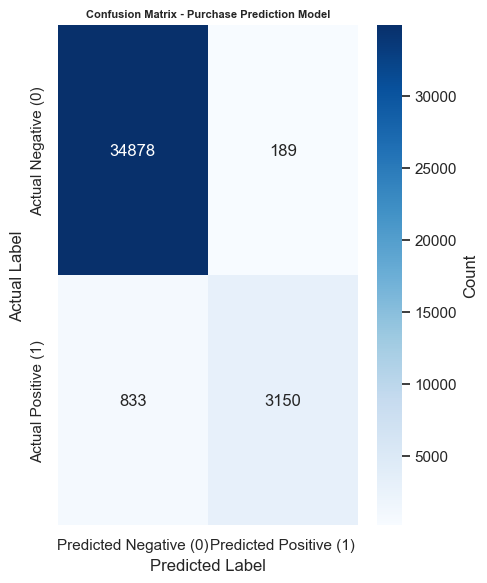


Confusion Matrix Values:
True Negatives (TN): 34878
False Positives (FP): 189
False Negatives (FN): 833
True Positives (TP): 3150


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = np.array([[TN, FP],
                              [FN, TP]])

plt.figure(figsize=(5, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
            yticklabels=['Actual Negative (0)', 'Actual Positive (1)'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Purchase Prediction Model', fontsize=8, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Values:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

Plotting the ROC curve and calculating the AUC score for the purchase prediction model.


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


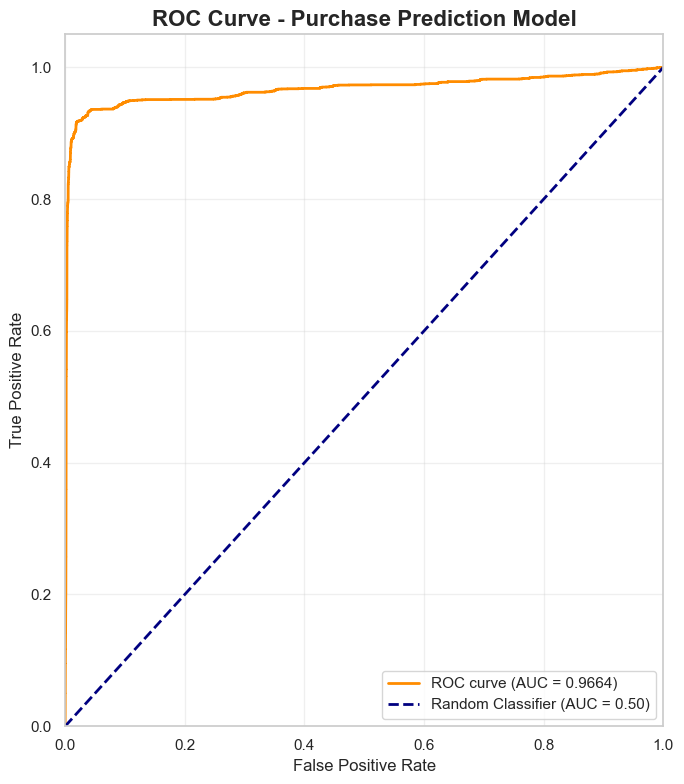


ROC AUC Score: 0.9664


In [28]:
!pip3 install scikit-learn
from sklearn.metrics import roc_curve, auc as sk_auc

pred_pd = predictions.select("label", "probability").toPandas()

y_true = pred_pd['label'].values
y_scores = np.array([float(p[1]) for p in pred_pd['probability'].values])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(7, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Purchase Prediction Model', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")

Problem Statement 2


Import Libraries

In [29]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, to_date, date_format, datediff, min, lit, when, countDistinct, hour
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

Aggregating purchases, views, carts, and active users at the hour level.

In [30]:
hourly_df = df.withColumn("date", to_date(col("event_time"))) \
              .withColumn("hour_of_day", hour(col("event_time"))) \
              .groupBy("date", "hour_of_day").agg(
    sum(when(col("event_type") == "purchase", col("price")).otherwise(0)).alias("hourly_revenue"),
    sum(when(col("event_type") == "view", 1).otherwise(0)).alias("hourly_views"),
    sum(when(col("event_type") == "cart", 1).otherwise(0)).alias("hourly_carts"),
    F.countDistinct("user_id").alias("hourly_active_users")
).orderBy("date", "hour_of_day")

Creating a proper timestamp column for each hour to support time-series ordering.

In [31]:
hourly_df = hourly_df.withColumn(
    "timestamp",
    F.concat(col("date").cast("string"), lit(" "), col("hour_of_day").cast("string"), lit(":00:00"))
).withColumn("timestamp", F.to_timestamp("timestamp"))

min_timestamp = hourly_df.select(min("timestamp")).collect()[0][0]

Building hour-index and extracting day-of-week for temporal modeling.

In [32]:
hourly_features = hourly_df.withColumn(
    "hour_index",
    (F.unix_timestamp(col("timestamp")) - F.unix_timestamp(lit(min_timestamp))) / 3600
).withColumn(
    "day_of_week",
    date_format(col("date"), "E")
)

Encoding day-of-week and hour-of-day as ML-ready vectors.

In [33]:
day_indexer = StringIndexer(inputCol="day_of_week", outputCol="day_index_raw")
day_encoder = OneHotEncoder(inputCol="day_index_raw", outputCol="day_of_week_vec")

hour_indexer = StringIndexer(inputCol="hour_of_day", outputCol="hour_index_raw")
hour_encoder = OneHotEncoder(inputCol="hour_index_raw", outputCol="hour_of_day_vec")


Building the ML feature vector with numeric + encoded time features.

In [34]:

numeric_features = ["hourly_views", "hourly_carts", "hourly_active_users", "hour_index"]
encoded_features = ["day_of_week_vec", "hour_of_day_vec"]

assembler = VectorAssembler(
    inputCols=numeric_features + encoded_features,
    outputCol="features"
)

Applying indexers, encoders, and vector assembler to create the final dataset.

In [35]:
pipeline_df = day_indexer.fit(hourly_features).transform(hourly_features)
pipeline_df = day_encoder.fit(pipeline_df).transform(pipeline_df)
pipeline_df = hour_indexer.fit(pipeline_df).transform(pipeline_df)
pipeline_df = hour_encoder.fit(pipeline_df).transform(pipeline_df)
final_df = assembler.transform(pipeline_df).select("timestamp", "date", "hour_of_day", "hourly_revenue", "features")

print(f"Total hourly records: {final_df.count()}")

Total hourly records: 34


Splitting the dataset into chronological train and test sets based on timestamps.

In [37]:

all_timestamps = final_df.select("timestamp").distinct().orderBy("timestamp").collect()
data_count = len(all_timestamps)
train_timestamp_count = int(data_count * 0.8)

if data_count < 50:
    print(f"WARNING: Only {data_count} unique hours found. Consider collecting more data.")

split_timestamp = all_timestamps[train_timestamp_count - 1][0]
print(f"Splitting data at: {split_timestamp}")
train_df = final_df.filter(col("timestamp") <= split_timestamp)
test_df = final_df.filter(col("timestamp") > split_timestamp)

print(f"Training on {train_df.count()} hours, Testing on {test_df.count()} hours.")

Splitting data at: 2019-11-01 22:00:00


Training on 27 hours, Testing on 7 hours.


Training the Random Forest regressor on hourly features.

In [38]:

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="hourly_revenue",
    predictionCol="predicted_revenue",
    numTrees=50,  # Increased for better performance
    maxDepth=10,
    seed=42
)
rf_model = rf.fit(train_df)

25/11/24 22:10:56 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 27 (= number of training instances)


Evaluating predictions using RMSE, MAE, and R².

In [39]:

if test_df.count() > 0:
    predictions = rf_model.transform(test_df)

    evaluator_rmse = RegressionEvaluator(
        labelCol="hourly_revenue",
        predictionCol="predicted_revenue",
        metricName="rmse"
    )
    evaluator_r2 = RegressionEvaluator(
        labelCol="hourly_revenue",
        predictionCol="predicted_revenue",
        metricName="r2"
    )
    evaluator_mae = RegressionEvaluator(
        labelCol="hourly_revenue",
        predictionCol="predicted_revenue",
        metricName="mae"
    )

    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)

    print("\n" + "="*50)
    print("Model 2: Hourly Revenue Prediction Results")
    print("="*50)
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("="*50)

    print("\nSample Predictions vs. Actual Revenue:")
    predictions.select("date", "hour_of_day", "hourly_revenue", "predicted_revenue").show(10)

    print("\nTop Feature Importances:")
    feature_imp = rf_model.featureImportances
    print(feature_imp)
else:
    print("Model 2: Not enough test data to evaluate the model.")


Model 2: Hourly Revenue Prediction Results
Root Mean Squared Error (RMSE): $52246.69
Mean Absolute Error (MAE): $41407.69
R-squared (R²): 0.7479

Sample Predictions vs. Actual Revenue:


+----------+-----------+------------------+------------------+
|      date|hour_of_day|    hourly_revenue| predicted_revenue|
+----------+-----------+------------------+------------------+
|2019-11-01|         23|218215.80999999988|242309.07786666643|
|2019-11-02|          0|345337.87000000017|340068.62779999955|
|2019-11-02|          1|414085.12000000046| 413321.0893333328|
|2019-11-02|          2|477067.75999999995| 389799.5463333327|
|2019-11-02|          3| 461222.7000000003|390155.45853333286|
|2019-11-02|          4| 449069.7900000002|  416984.876933333|
|2019-11-02|          5| 214500.9900000004|  283807.880533333|
+----------+-----------+------------------+------------------+


Top Feature Importances:
(29,[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28],[0.13590587623167372,0.4162848215672894,0.2653927450231557,0.09408607081062755,0.017325953829866885,0.0007659756121516026,0.002103250537908371,0.0039069056600312055,0.011006299665013,0.01442017529125

Collecting hourly revenue predictions into Pandas for visualization.

In [40]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Collecting prediction data for visualization...")

predictions_pd = predictions.select(
    "date", "hour_of_day", "hourly_revenue", "predicted_revenue"
).limit(500).toPandas()

print(f"Collected {len(predictions_pd)} predictions for visualization")

Collected 7 predictions for visualization


Plotting a line chart comparing actual vs. predicted hourly revenue over time.

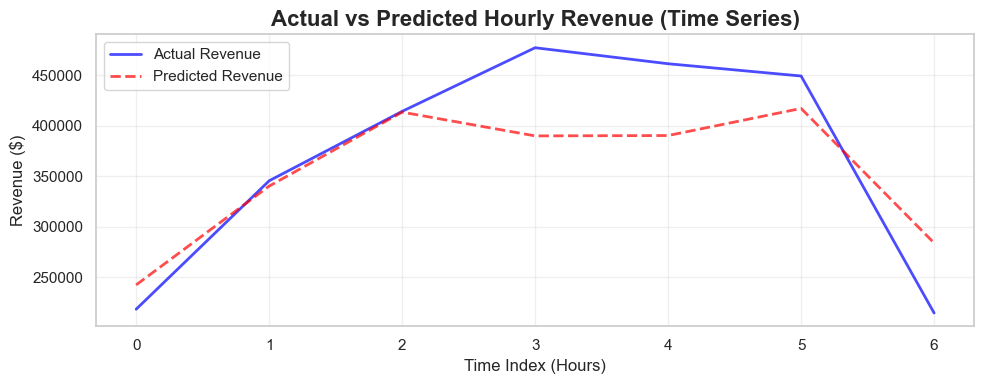

In [41]:
plt.figure(figsize=(10, 4))
predictions_pd['time_index'] = range(len(predictions_pd))

plt.plot(predictions_pd['time_index'], predictions_pd['hourly_revenue'],
         label='Actual Revenue', color='blue', linewidth=2, alpha=0.7)
plt.plot(predictions_pd['time_index'], predictions_pd['predicted_revenue'],
         label='Predicted Revenue', color='red', linewidth=2, alpha=0.7, linestyle='--')

plt.xlabel('Time Index (Hours)', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.title('Actual vs Predicted Hourly Revenue (Time Series)', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Plotting actual vs. predicted revenue with a perfect prediction line and correlation.

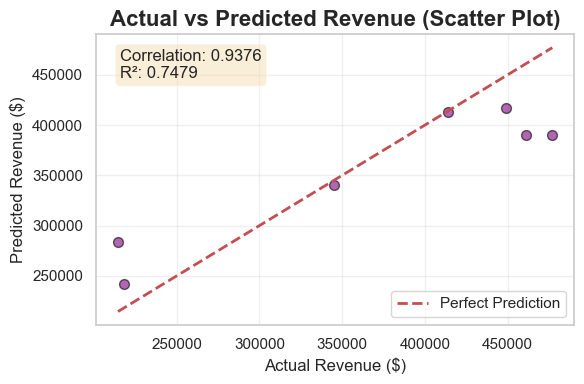

In [42]:

plt.figure(figsize=(6, 4))

plt.scatter(predictions_pd['hourly_revenue'], predictions_pd['predicted_revenue'],
            alpha=0.6, edgecolors='black', s=50, color='purple')

min_val = np.min([predictions_pd['hourly_revenue'].min(), predictions_pd['predicted_revenue'].min()])
max_val = np.max([predictions_pd['hourly_revenue'].max(), predictions_pd['predicted_revenue'].max()])
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Revenue ($)', fontsize=12)
plt.ylabel('Predicted Revenue ($)', fontsize=12)
plt.title('Actual vs Predicted Revenue (Scatter Plot)', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

from scipy.stats import pearsonr
correlation, _ = pearsonr(predictions_pd['hourly_revenue'], predictions_pd['predicted_revenue'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}\nR²: {r2:.4f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

Visualizing prediction errors and prints their mean and std.

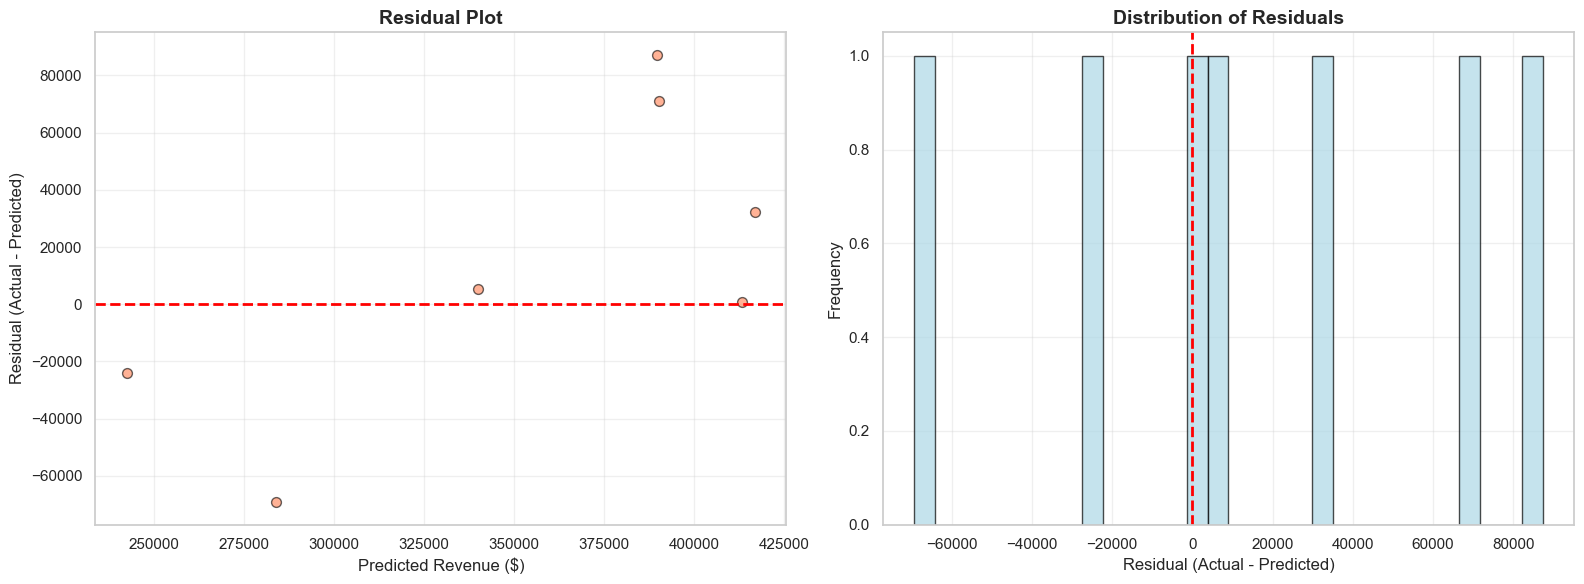

Mean Residual: $14721.93
Std Dev of Residuals: $54146.21


In [43]:

predictions_pd['residual'] = predictions_pd['hourly_revenue'] - predictions_pd['predicted_revenue']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(predictions_pd['predicted_revenue'], predictions_pd['residual'],
                alpha=0.6, edgecolors='black', s=50, color='coral')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Revenue ($)', fontsize=12)
axes[0].set_ylabel('Residual (Actual - Predicted)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(predictions_pd['residual'], bins=30, color='lightblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (Actual - Predicted)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Residual: ${predictions_pd['residual'].mean():.2f}")
print(f"Std Dev of Residuals: ${predictions_pd['residual'].std():.2f}")

Problemn Statement 3: FOCUS CUSTOMER SEGMENTATION (CLUSTERING PART)

Aggregating users with RFM + behavioral features.

In [44]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, max, min, datediff, lit, to_date, coalesce, when, count
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

print("Starting User-Level Aggregation...")

MAX_EVENT_TIME = df.select(max("event_time")).collect()[0][0]
TODAY = to_date(lit(MAX_EVENT_TIME)).alias("today_date")

views_count = count(when(col("event_type") == "view", True))
cart_count = count(when(col("event_type") == "cart", True))
purchase_count = count(when(col("event_type") == "purchase", True))

customer_features_enhanced = df.groupBy("user_id").agg(
    views_count.alias("views"),
    cart_count.alias("cart_adds"),
    purchase_count.alias("purchases"),
    F.sum(F.when(col("event_type")=="purchase", col("price")).otherwise(0)).alias("total_spent"),
    max(F.when(col("event_type") == "purchase", to_date(col("event_time")))).alias("last_purchase_date"),
    min(col("event_time")).alias("first_activity_time"),
    F.countDistinct("category_code").alias("unique_categories"),
    F.avg("hour").alias("avg_hour"),
    when(
        views_count > 0,
        cart_count / views_count
    ).otherwise(0.0).alias("cart_view_ratio"),
)

customer_features_final = customer_features_enhanced.withColumn(

    "recency_days",
    datediff(
        TODAY,
        coalesce(
            col("last_purchase_date"),
            to_date(col("first_activity_time"))
        )
    )
).withColumn(
    "AOV",
    when(col("purchases") > 0, col("total_spent") / col("purchases")).otherwise(0)
)

customer_features_final = customer_features_final.na.fill(0).filter(col("purchases") >= 0)

Starting User-Level Aggregation...


Assembling and scaling user features for clustering.

In [45]:

feature_cols = [
    "views", "cart_adds", "purchases", "total_spent", "unique_categories",
    "avg_hour", "cart_view_ratio", "recency_days", "AOV"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled")
df_assembled = assembler.transform(customer_features_final)

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)


Training K-Means and assigning cluster labels.

In [46]:

print("Starting K-Means Training...")
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=5, seed=42)
model = kmeans.fit(df_scaled)
clusters = model.transform(df_scaled)


25/11/24 22:13:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Starting K-Means Training...


Evaluating clustering quality using silhouette score.

In [47]:
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette")
silhouette_score = evaluator.evaluate(clusters)
print(f"Model 3: Customer Segmentation Silhouette Score (K=5): {silhouette_score:.4f}")

Model 3: Customer Segmentation Silhouette Score (K=5): 0.4591


Profiling clusters to understand user behavior patterns.

In [48]:
print("Final Cluster Profiles (Unscaled Averages)")
clusters.groupBy("cluster").agg(
    F.count("user_id").alias("num_customers"),
    F.avg("recency_days").alias("avg_recency_days"),
    F.avg("purchases").alias("avg_purchases"),
    F.avg("total_spent").alias("avg_spent"),
    F.avg("AOV").alias("avg_AOV"),
    F.avg("cart_view_ratio").alias("avg_cart_view_ratio")
).orderBy("cluster").show(truncate=False)

Final Cluster Profiles (Unscaled Averages)


+-------+-------------+------------------+-------------------+------------------+------------------+---------------------+
|cluster|num_customers|avg_recency_days  |avg_purchases      |avg_spent         |avg_AOV           |avg_cart_view_ratio  |
+-------+-------------+------------------+-------------------+------------------+------------------+---------------------+
|0      |209736       |1.0889403821947592|0.04587195331273601|6.8006106724644235|6.2181647054710325|0.004214900177647181 |
|1      |22566        |1.0198971904635292|0.14588318709563058|20.09589337942035 |15.158615399062255|0.0034187640064236285|
|2      |4231         |0.7352871661545733|2.1271567005436065 |1413.6400189080684|831.4429582440163 |0.15796189957418488  |
|3      |57790        |0.0               |0.07193286035646305|10.150942896694968|8.86076834227375  |0.004686877358197313 |
|4      |5685         |0.7660510114335972|1.053825857519789  |223.07015655233255|165.31746284605086|0.7322722955414142   |
+-------+-------

Collecting cluster profiles into Pandas for analysis.

In [49]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Collecting cluster profiles for visualization...")
cluster_profiles = clusters.groupBy("cluster").agg(
    F.count("user_id").alias("num_customers"),
    F.avg("recency_days").alias("avg_recency_days"),
    F.avg("purchases").alias("avg_purchases"),
    F.avg("total_spent").alias("avg_spent"),
    F.avg("AOV").alias("avg_AOV"),
    F.avg("cart_view_ratio").alias("avg_cart_view_ratio"),
    F.avg("views").alias("avg_views"),
    F.avg("cart_adds").alias("avg_cart_adds"),
    F.avg("unique_categories").alias("avg_unique_categories"),
    F.avg("avg_hour").alias("avg_hour_of_day")
).orderBy("cluster").toPandas()

print("Cluster profiles collected!")
print(cluster_profiles)

Cluster profiles collected!
   cluster  num_customers  avg_recency_days  avg_purchases    avg_spent  \
0        0         209736          1.088940       0.045872     6.800611   
1        1          22566          1.019897       0.145883    20.095893   
2        2           4231          0.735287       2.127157  1413.640019   
3        3          57790          0.000000       0.071933    10.150943   
4        4           5685          0.766051       1.053826   223.070157   

      avg_AOV  avg_cart_view_ratio  avg_views  avg_cart_adds  \
0    6.218165             0.004215   4.532550       0.022071   
1   15.158615             0.003419  29.124922       0.084330   
2  831.442958             0.157962  10.732451       1.046561   
3    8.860768             0.004687   4.337636       0.025593   
4  165.317463             0.732272   6.424626       2.642568   

   avg_unique_categories  avg_hour_of_day  
0               0.839756         9.784711  
1               3.004387         9.224074  
2   

Shhowing cluster sizes with a pie chart and counts.

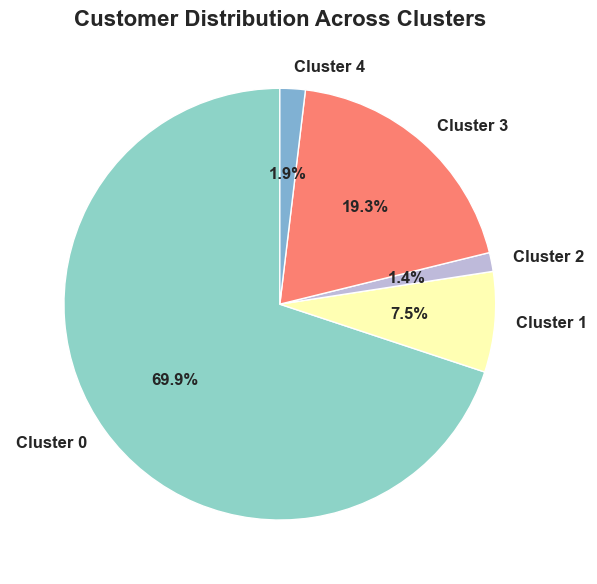

Cluster 0.0: 209,736 customers
Cluster 1.0: 22,566 customers
Cluster 2.0: 4,231 customers
Cluster 3.0: 57,790 customers
Cluster 4.0: 5,685 customers


In [50]:
plt.figure(figsize=(8, 6))
colors = plt.cm.Set3(range(len(cluster_profiles)))
plt.pie(cluster_profiles['num_customers'],
        labels=[f'Cluster {i}' for i in cluster_profiles['cluster']],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Customer Distribution Across Clusters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

for idx, row in cluster_profiles.iterrows():
    print(f"Cluster {row['cluster']}: {row['num_customers']:,.0f} customers")

Plotting a normalized heatmap of cluster feature profiles.

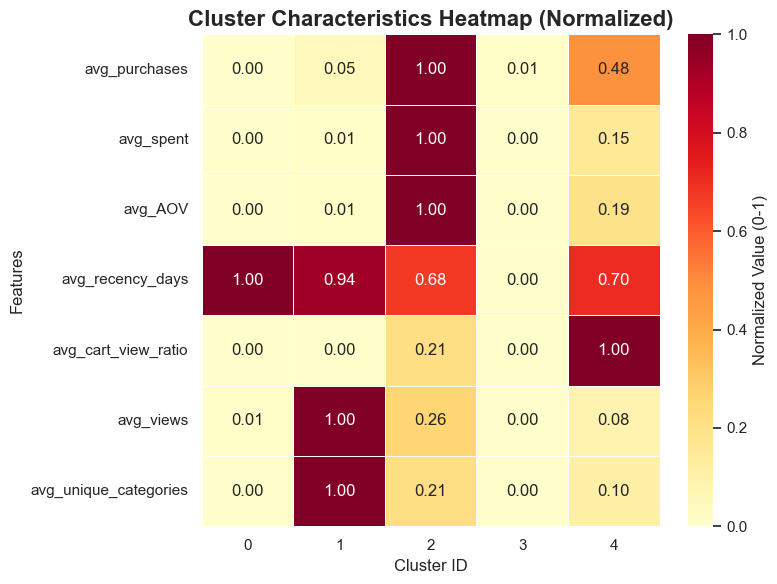

In [51]:

heatmap_data = cluster_profiles[['cluster', 'avg_purchases', 'avg_spent', 'avg_AOV',
                                   'avg_recency_days', 'avg_cart_view_ratio',
                                   'avg_views', 'avg_unique_categories']].set_index('cluster')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
heatmap_normalized = pd.DataFrame(
    scaler.fit_transform(heatmap_data),
    columns=heatmap_data.columns,
    index=heatmap_data.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_normalized.T, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Normalized Value (0-1)'}, linewidths=0.5)
plt.title('Cluster Characteristics Heatmap (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

Creating a 2×3 bar chart grid comparing clusters across key metrics.

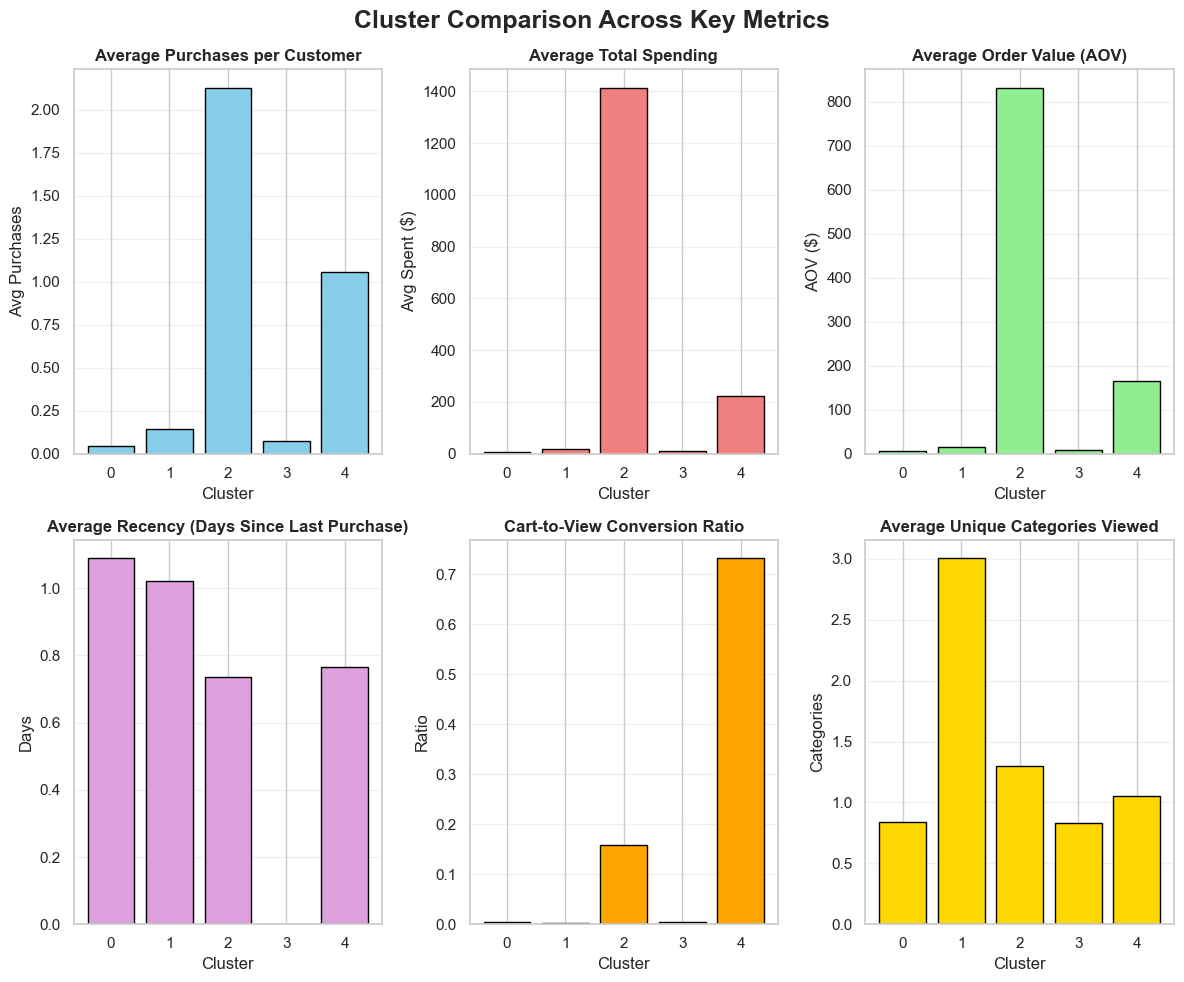

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
fig.suptitle('Cluster Comparison Across Key Metrics', fontsize=18, fontweight='bold')

# Metric 1: Average Purchases
axes[0, 0].bar(cluster_profiles['cluster'], cluster_profiles['avg_purchases'], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Average Purchases per Customer', fontweight='bold')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Avg Purchases')
axes[0, 0].grid(axis='y', alpha=0.3)

# Metric 2: Average Spent
axes[0, 1].bar(cluster_profiles['cluster'], cluster_profiles['avg_spent'], color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Average Total Spending', fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Avg Spent ($)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Metric 3: Average Order Value (AOV)
axes[0, 2].bar(cluster_profiles['cluster'], cluster_profiles['avg_AOV'], color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Average Order Value (AOV)', fontweight='bold')
axes[0, 2].set_xlabel('Cluster')
axes[0, 2].set_ylabel('AOV ($)')
axes[0, 2].grid(axis='y', alpha=0.3)

# Metric 4: Recency
axes[1, 0].bar(cluster_profiles['cluster'], cluster_profiles['avg_recency_days'], color='plum', edgecolor='black')
axes[1, 0].set_title('Average Recency (Days Since Last Purchase)', fontweight='bold')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Days')
axes[1, 0].grid(axis='y', alpha=0.3)

# Metric 5: Cart-to-View Ratio
axes[1, 1].bar(cluster_profiles['cluster'], cluster_profiles['avg_cart_view_ratio'], color='orange', edgecolor='black')
axes[1, 1].set_title('Cart-to-View Conversion Ratio', fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Ratio')
axes[1, 1].grid(axis='y', alpha=0.3)

# Metric 6: Unique Categories
axes[1, 2].bar(cluster_profiles['cluster'], cluster_profiles['avg_unique_categories'], color='gold', edgecolor='black')
axes[1, 2].set_title('Average Unique Categories Viewed', fontweight='bold')
axes[1, 2].set_xlabel('Cluster')
axes[1, 2].set_ylabel('Categories')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Problem Statement 4: FOCUS PRODUCT RECOMMENDATION (PERSONALIZATION)

Aggregating products bought/viewed per session for market basket analysis.

In [53]:
from pyspark.sql import functions as F


transactions = df.groupBy("user_session").agg(
    F.collect_set("product_id").alias("products")
)

transactions.show(5, truncate=False)

+------------------------------------+------------------------------------------------------------------+
|user_session                        |products                                                          |
+------------------------------------+------------------------------------------------------------------+
|000009c4-a1dd-4764-87d9-24f3d7e43c4f|[1005129.0, 5100855.0, 1004659.0, 1005073.0, 1002544.0]           |
|0000145a-b981-424b-ba76-5e8f50beb12d|[1.7302616E7]                                                     |
|00006bc8-78c7-4100-ba97-37352c9af491|[7006202.0, 7006200.0, 7006284.0, 7006403.0, 7005750.0, 7005751.0]|
|00008ebc-a8c1-48c2-beb9-aa4448e93639|[1005204.0, 1005217.0]                                            |
|0000b0f0-9fb0-41a3-bdfa-3fa1d28b2e7c|[3601508.0]                                                       |
+------------------------------------+------------------------------------------------------------------+
only showing top 5 rows


Finding frequent product sets and association rules using FP-Growth.

In [54]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="products", minSupport=0.001, minConfidence=0.2)
model = fpGrowth.fit(transactions)

frequent_itemsets = model.freqItemsets
frequent_itemsets.show(10, truncate=False)

association_rules = model.associationRules
association_rules.show(10, truncate=False)

+----------------------+-----+
|items                 |freq |
+----------------------+-----+
|[1004856.0]           |12398|
|[1005115.0]           |11369|
|[1005115.0, 1004856.0]|523  |
|[1004767.0]           |11111|
|[1004767.0, 1004856.0]|1497 |
|[1005105.0]           |6898 |
|[1005105.0, 1005115.0]|1714 |
|[1004249.0]           |6738 |
|[1004249.0, 1005115.0]|1421 |
|[1004249.0, 1005105.0]|563  |
+----------------------+-----+
only showing top 10 rows
+-----------+-----------+-------------------+------------------+---------------------+
|antecedent |consequent |confidence         |lift              |support              |
+-----------+-----------+-------------------+------------------+---------------------+
|[1004858.0]|[1004856.0]|0.2825696316262354 |10.284891869496963|0.0013938780168373374|
|[1005105.0]|[1005115.0]|0.24847781965787186|9.86259586779766  |0.003798262195324636 |
|[1004833.0]|[1004856.0]|0.2570268074735987 |9.35519116903764  |0.003505747253794384 |
|[1005157.0]|[10052

Generating product recommendations for each session based on association rules.

In [55]:

recommendations = model.transform(transactions)
recommendations.show(5, truncate=False)

+------------------------------------+------------------------------------------------------------------+----------+
|user_session                        |products                                                          |prediction|
+------------------------------------+------------------------------------------------------------------+----------+
|000009c4-a1dd-4764-87d9-24f3d7e43c4f|[1005129.0, 5100855.0, 1004659.0, 1005073.0, 1002544.0]           |[]        |
|0000145a-b981-424b-ba76-5e8f50beb12d|[1.7302616E7]                                                     |[]        |
|00006bc8-78c7-4100-ba97-37352c9af491|[7006202.0, 7006200.0, 7006284.0, 7006403.0, 7005750.0, 7005751.0]|[]        |
|00008ebc-a8c1-48c2-beb9-aa4448e93639|[1005204.0, 1005217.0]                                            |[]        |
|0000b0f0-9fb0-41a3-bdfa-3fa1d28b2e7c|[3601508.0]                                                       |[]        |
+------------------------------------+--------------------------

Adding product category info to association rules for better insights.

In [56]:
product_categories = df.select("product_id", "category_code").distinct()
rules_with_categories = association_rules.join(
    product_categories.alias("p1"), association_rules.antecedent[0] == F.col("p1.product_id")
).join(
    product_categories.alias("p2"), association_rules.consequent[0] == F.col("p2.product_id")
)

rules_with_categories.select(
    "antecedent", "consequent", "confidence", "lift",
    F.col("p1.category_code").alias("antecedent_category"),
    F.col("p2.category_code").alias("consequent_category")
).show(10, truncate=False)


+-----------+-----------+-------------------+------------------+---------------------------+---------------------------+
|antecedent |consequent |confidence         |lift              |antecedent_category        |consequent_category        |
+-----------+-----------+-------------------+------------------+---------------------------+---------------------------+
|[1005098.0]|[1004856.0]|0.28304027226318773|10.302022118181467|electronics.smartphone     |electronics.smartphone     |
|[1004785.0]|[1004781.0]|0.22185539782106306|46.39214317207372 |electronics.smartphone     |electronics.smartphone     |
|[4802036.0]|[4804056.0]|0.28912919749573135|26.03714877923094 |electronics.audio.headphone|electronics.audio.headphone|
|[1004246.0]|[1004249.0]|0.29246487867177523|19.587030080817247|electronics.smartphone     |electronics.smartphone     |
|[1004249.0]|[1005115.0]|0.21089344018996736|8.370794522533599 |electronics.smartphone     |electronics.smartphone     |
|[1004781.0]|[1004785.0]|0.31139

Creating Transaction Baskets

In [57]:

from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth

print("\nStep 1: Creating transaction baskets...")
transactions = df.groupBy("user_session").agg(
    F.collect_set("product_id").alias("products"),
    F.collect_set("category_code").alias("categories"),
    F.countDistinct("product_id").alias("basket_size")
)

print(f"Total sessions (transactions): {transactions.count()}")
print("\nSample transactions:")
transactions.show(5, truncate=False)
print("\nBasket Size Distribution:")
transactions.groupBy("basket_size").count().orderBy("basket_size").show(10)



Step 1: Creating transaction baskets...


Total sessions (transactions): 451259

Sample transactions:


+------------------------------------+------------------------------------------------------------------+--------------------------------------------+-----------+
|user_session                        |products                                                          |categories                                  |basket_size|
+------------------------------------+------------------------------------------------------------------+--------------------------------------------+-----------+
|000009c4-a1dd-4764-87d9-24f3d7e43c4f|[1005129.0, 5100855.0, 1004659.0, 1005073.0, 1002544.0]           |[electronics.clocks, electronics.smartphone]|5          |
|0000145a-b981-424b-ba76-5e8f50beb12d|[1.7302616E7]                                                     |[]                                          |1          |
|00006bc8-78c7-4100-ba97-37352c9af491|[7006202.0, 7006200.0, 7006284.0, 7006403.0, 7005750.0, 7005751.0]|[kids.carriage]                             |6          |
|00008ebc-a8c1-48c2-be

+-----------+------+
|basket_size| count|
+-----------+------+
|          1|228933|
|          2| 78958|
|          3| 43457|
|          4| 27180|
|          5| 18044|
|          6| 12509|
|          7|  9100|
|          8|  6691|
|          9|  4968|
|         10|  3804|
+-----------+------+
only showing top 10 rows


Training FP-Growth Model

In [58]:

print("\nStep 2: Training FP-Growth model...")
fpGrowth = FPGrowth(
    itemsCol="products",
    minSupport=0.001,
    minConfidence=0.3
)
model = fpGrowth.fit(transactions)


Step 2: Training FP-Growth model...


Extracting Frequent Itemsets

In [59]:

print("\nStep 3: Extracting frequent itemsets...")
frequent_itemsets = model.freqItemsets
print(f"Total frequent itemsets found: {frequent_itemsets.count()}")
print("\nTop 10 Frequent Itemsets:")
frequent_itemsets.orderBy(F.desc("freq")).show(10, truncate=False)


Step 3: Extracting frequent itemsets...


Total frequent itemsets found: 348

Top 10 Frequent Itemsets:
+-----------+-----+
|items      |freq |
+-----------+-----+
|[1004856.0]|12398|
|[1005115.0]|11369|
|[1004767.0]|11111|
|[1005105.0]|6898 |
|[1004249.0]|6738 |
|[1004833.0]|6155 |
|[1002544.0]|5981 |
|[1004870.0]|5627 |
|[1005160.0]|5059 |
|[4804056.0]|5011 |
+-----------+-----+
only showing top 10 rows


Generating Association Rules

In [60]:

print("\nStep 4: Generating association rules...")
association_rules = model.associationRules
print(f"Total association rules: {association_rules.count()}")
print("\nTop 10 Association Rules (by confidence):")
association_rules.orderBy(F.desc("confidence")).show(10, truncate=False)

print("\nTop 10 Association Rules (by lift):")
association_rules.orderBy(F.desc("lift")).show(10, truncate=False)


Step 4: Generating association rules...
Total association rules: 6

Top 10 Association Rules (by confidence):
+-----------+-----------+-------------------+------------------+---------------------+
|antecedent |consequent |confidence         |lift              |support              |
+-----------+-----------+-------------------+------------------+---------------------+
|[4804055.0]|[4804056.0]|0.41453831041257366|37.330701141182914|0.0018703228079661569|
|[1005157.0]|[1005239.0]|0.3778656126482213 |50.77881432341385 |0.0010592586519050035|
|[1005100.0]|[1004856.0]|0.3311163895486936 |12.051883435340695|0.003089135064342207 |
|[1005239.0]|[1005160.0]|0.32281119714115547|28.794516309689797|0.0024021681562029786|
|[1005161.0]|[1005160.0]|0.3160220994475138 |28.188933894956637|0.0012675647466310921|
|[1004781.0]|[1004785.0]|0.3113994439295644 |46.39214317207372 |0.0014891669750631013|
+-----------+-----------+-------------------+------------------+---------------------+


Top 10 Associatio

Enrich Rules with Category & Brand

In [61]:

print("\nStep 5: Enriching rules with category information...")

product_categories = df.select("product_id", "category_code", "brand").distinct()

rules_enhanced = association_rules.withColumn("antecedent_product", F.col("antecedent")[0]) \
                                  .withColumn("consequent_product", F.col("consequent")[0])

rules_with_categories = rules_enhanced.join(
    product_categories.alias("p1"),
    rules_enhanced.antecedent_product == F.col("p1.product_id"),
    "left"
).join(
    product_categories.alias("p2"),
    rules_enhanced.consequent_product == F.col("p2.product_id"),
    "left"
)

rules_final = rules_with_categories.select(
    "antecedent",
    "consequent",
    "confidence",
    "lift",
    "support",
    F.col("p1.category_code").alias("antecedent_category"),
    F.col("p2.category_code").alias("consequent_category"),
    F.col("p1.brand").alias("antecedent_brand"),
    F.col("p2.brand").alias("consequent_brand")
)

print("\nEnriched Association Rules:")
rules_final.orderBy(F.desc("lift")).show(20, truncate=False)


Step 5: Enriching rules with category information...

Enriched Association Rules:


+-----------+-----------+-------------------+------------------+---------------------+---------------------------+---------------------------+----------------+----------------+
|antecedent |consequent |confidence         |lift              |support              |antecedent_category        |consequent_category        |antecedent_brand|consequent_brand|
+-----------+-----------+-------------------+------------------+---------------------+---------------------------+---------------------------+----------------+----------------+
|[1005157.0]|[1005239.0]|0.3778656126482213 |50.77881432341385 |0.0010592586519050035|electronics.smartphone     |electronics.smartphone     |xiaomi          |xiaomi          |
|[1004781.0]|[1004785.0]|0.3113994439295644 |46.39214317207372 |0.0014891669750631013|electronics.smartphone     |electronics.smartphone     |huawei          |huawei          |
|[4804055.0]|[4804056.0]|0.41453831041257366|37.330701141182914|0.0018703228079661569|electronics.audio.headphone|e

Cross-Category Analysis

In [62]:

print("\nStep 6: Cross-Category Buying Patterns...")
cross_category = rules_final.filter(
    (F.col("antecedent_category").isNotNull()) &
    (F.col("consequent_category").isNotNull()) &
    (F.col("antecedent_category") != F.col("consequent_category"))
)

print(f"\nTotal cross-category rules: {cross_category.count()}")
print("\nTop Cross-Category Associations:")
cross_category.groupBy("antecedent_category", "consequent_category").agg(
    F.count("*").alias("rule_count"),
    F.avg("confidence").alias("avg_confidence"),
    F.avg("lift").alias("avg_lift")
).orderBy(F.desc("avg_lift")).show(20, truncate=False)


Step 6: Cross-Category Buying Patterns...



Total cross-category rules: 0

Top Cross-Category Associations:


+-------------------+-------------------+----------+--------------+--------+
|antecedent_category|consequent_category|rule_count|avg_confidence|avg_lift|
+-------------------+-------------------+----------+--------------+--------+
+-------------------+-------------------+----------+--------------+--------+



Generate Recommendations

In [63]:

print("\nStep 7: Generating recommendations for sample sessions...")
recommendations = model.transform(transactions)
print("\nSample Recommendations:")
recommendations.select("products", "prediction").show(5, truncate=False)

print("\n" + "="*70)
print("MODEL 4 TRAINING COMPLETE!")
print("="*70)


Step 7: Generating recommendations for sample sessions...

Sample Recommendations:


+------------------------------------------------------------------+----------+
|products                                                          |prediction|
+------------------------------------------------------------------+----------+
|[1005129.0, 5100855.0, 1004659.0, 1005073.0, 1002544.0]           |[]        |
|[1.7302616E7]                                                     |[]        |
|[7006202.0, 7006200.0, 7006284.0, 7006403.0, 7005750.0, 7005751.0]|[]        |
|[1005204.0, 1005217.0]                                            |[]        |
|[3601508.0]                                                       |[]        |
+------------------------------------------------------------------+----------+
only showing top 5 rows

MODEL 4 TRAINING COMPLETE!


Collecting top association rules and frequent itemsets into Pandas for visualization.

In [64]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Collecting data for visualizations...")

rules_pd = rules_final.limit(100).toPandas()  # Top 100 rules
frequent_pd = frequent_itemsets.orderBy(F.desc("freq")).limit(50).toPandas()

Plotting the top 15 most frequent product itemsets as a horizontal bar chart.

/var/folders/wl/fsx4ltzj4150thpw8xcm4pn00000gn/T/ipykernel_47689/2309607236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_itemsets['items_str'] = top_itemsets['items'].apply(lambda x: str(x[:3]) if len(x) > 3 else str(x))


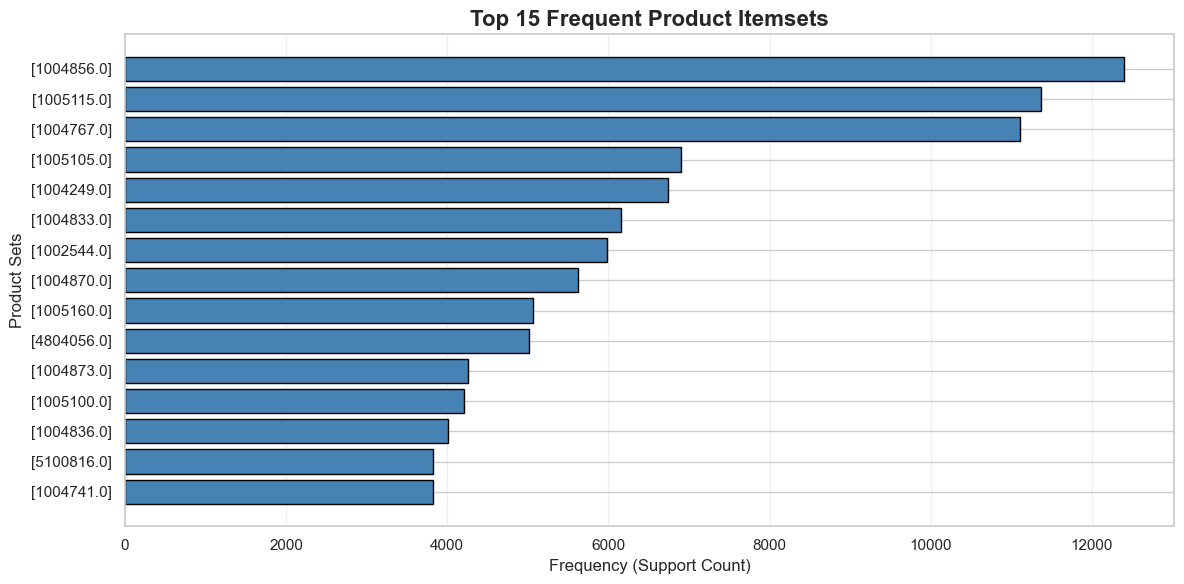

In [65]:
plt.figure(figsize=(12, 6))

top_itemsets = frequent_pd.head(15)
top_itemsets['items_str'] = top_itemsets['items'].apply(lambda x: str(x[:3]) if len(x) > 3 else str(x))

plt.barh(range(len(top_itemsets)), top_itemsets['freq'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_itemsets)), top_itemsets['items_str'])
plt.xlabel('Frequency (Support Count)', fontsize=12)
plt.ylabel('Product Sets', fontsize=12)
plt.title('Top 15 Frequent Product Itemsets', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Plots association rules as a bubble chart showing confidence vs. lift, with bubble size representing support.

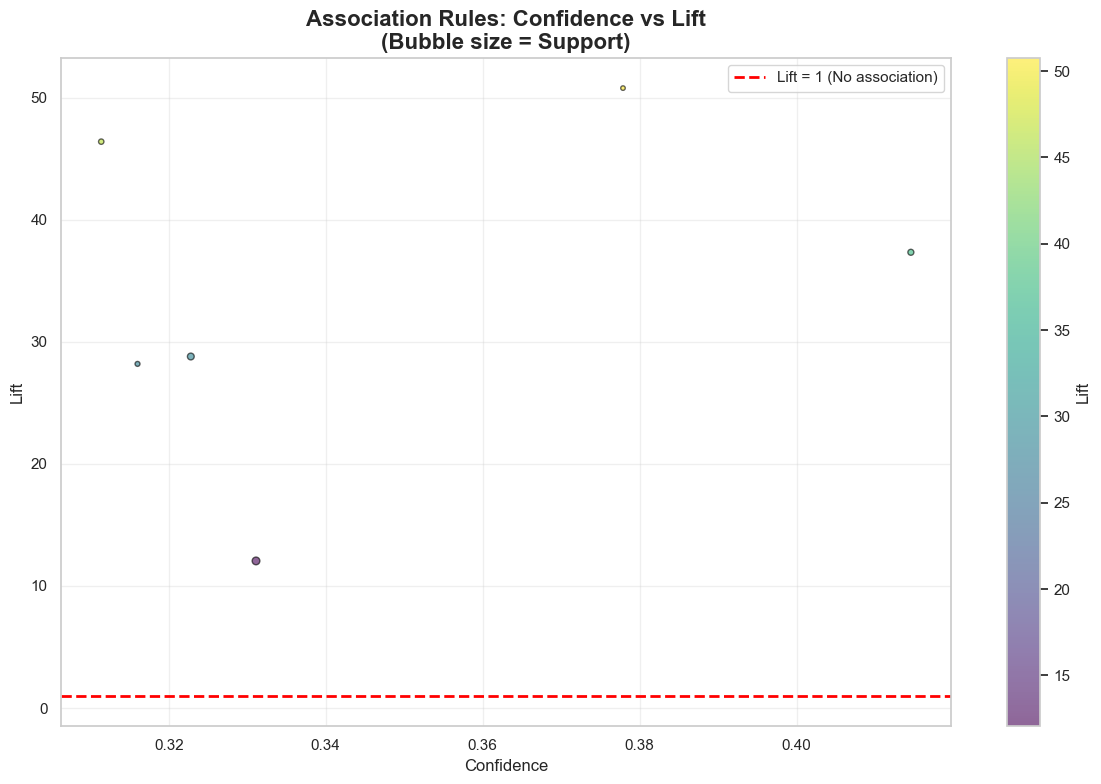

In [66]:

plt.figure(figsize=(12, 8))

scatter = plt.scatter(rules_pd['confidence'], rules_pd['lift'],
                     s=rules_pd['support']*10000,  # Size by support
                     alpha=0.6, edgecolors='black', c=rules_pd['lift'],
                     cmap='viridis')

plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.title('Association Rules: Confidence vs Lift\n(Bubble size = Support)',
          fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Lift')
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Lift = 1 (No association)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Bar chart of top 15 association rules ranked by lift.

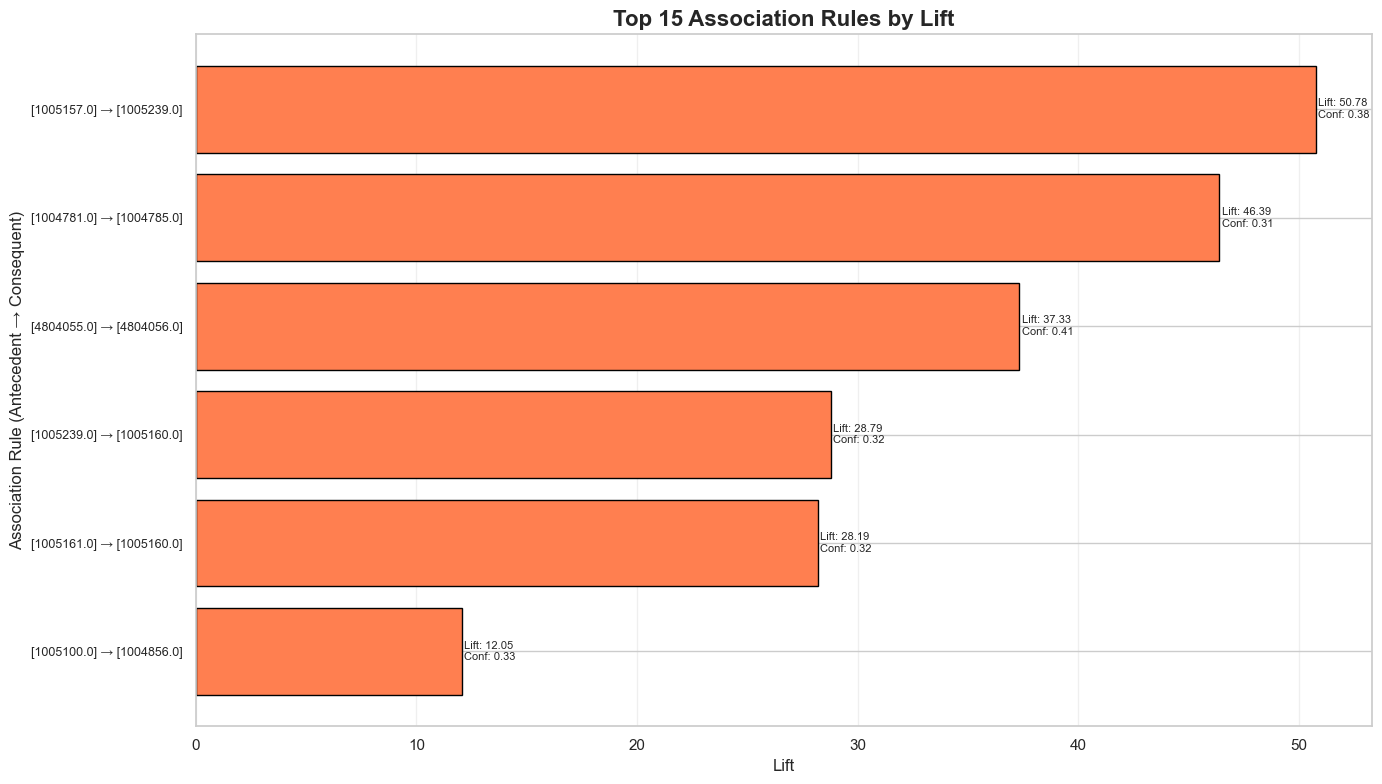

In [67]:

plt.figure(figsize=(14, 8))

top_rules = rules_pd.nlargest(15, 'lift').copy()
top_rules['rule'] = top_rules.apply(
    lambda row: f"{str(row['antecedent'][:1])} → {str(row['consequent'][:1])}", axis=1
)

bars = plt.barh(range(len(top_rules)), top_rules['lift'], color='coral', edgecolor='black')
plt.yticks(range(len(top_rules)), top_rules['rule'], fontsize=9)
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Association Rule (Antecedent → Consequent)', fontsize=12)
plt.title('Top 15 Association Rules by Lift', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

for i, (bar, lift, conf) in enumerate(zip(bars, top_rules['lift'], top_rules['confidence'])):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'Lift: {lift:.2f}\nConf: {conf:.2f}',
             ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

BASKET SIZE DISTRIBUTION

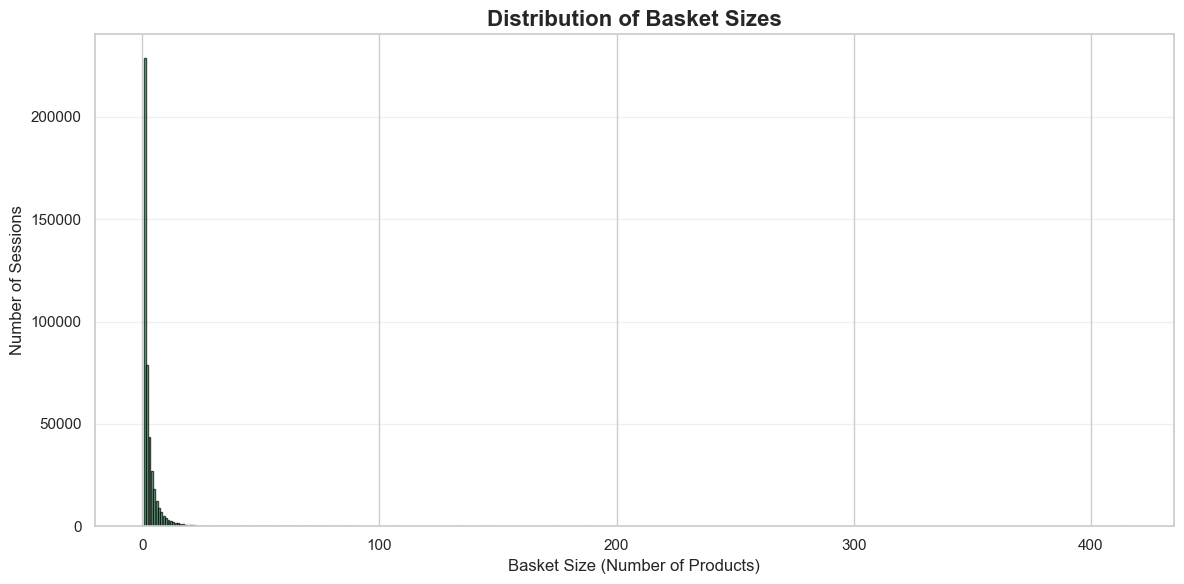


Average basket size: 56.78
Median basket size: 48


In [68]:

basket_dist = transactions.groupBy("basket_size").count().orderBy("basket_size").toPandas()

plt.figure(figsize=(12, 6))
plt.bar(basket_dist['basket_size'], basket_dist['count'],
        color='mediumseagreen', edgecolor='black', alpha=0.7)
plt.xlabel('Basket Size (Number of Products)', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
plt.title('Distribution of Basket Sizes', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAverage basket size: {basket_dist['basket_size'].mean():.2f}")
print(f"Median basket size: {basket_dist['basket_size'].median():.0f}")